In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import sys

sys.path.append('..')

# Set the path to your images_reshaped directory
base_path = '../images_reshaped'

# Initialize lists to store data
data = []

# Iterate through the directory structure
for category in ['deadly', 'edible', 'poisonous', 'conditionally_edible']:
    category_path = os.path.join(base_path, category)
    for species_folder in os.listdir(category_path):
        species_path = os.path.join(category_path, species_folder)
        if os.path.isdir(species_path):
            for image_file in os.listdir(species_path):
                if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(species_path, image_file)
                    
                    # Load and preprocess the image
                    img = Image.open(image_path)
                    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                    
                    data.append({
                        'image_path': image_path,
                        'category': category,
                        'species': species_folder,
                        'image': img_array
                    })

# Create the DataFrame
df = pd.DataFrame(data)

# Add the 'edible' column
df['edible'] = (df['category'] == 'edible').astype(int)

# Encode categories and species
le_category = LabelEncoder()
le_species = LabelEncoder()
df['category_encoded'] = le_category.fit_transform(df['category'])
df['species_encoded'] = le_species.fit_transform(df['species'])

# Save the DataFrame without the 'image' column
df_save = df.drop(columns=['image'])
df_save.to_pickle('mushroom_metadata.pkl')

# Save the image data separately
np.save('mushroom_images.npy', np.stack(df['image'].values))

print("Data preprocessing completed.")
print(f"Metadata saved as 'mushroom_metadata.pkl'.")
print(f"Image data saved as 'mushroom_images.npy'.")
print(f"Total images processed: {len(df)}")
print(f"Number of edible mushrooms: {df['edible'].sum()}")
print(f"Number of non-edible mushrooms: {len(df) - df['edible'].sum()}")
print(f"Number of unique species: {df['species'].nunique()}")
print(f"Image shape: {df['image'].iloc[0].shape}")

Data preprocessing completed.
Metadata saved as 'mushroom_metadata.pkl'.
Image data saved as 'mushroom_images.npy'.
Total images processed: 8345
Number of edible mushrooms: 2433
Number of non-edible mushrooms: 5912
Number of unique species: 247
Image shape: (224, 224, 3)


In [3]:
df.head()

,image_path,category,species,image,edible,category_encoded,species_encoded
0,../images_reshaped/deadly/Lepiota_castanea/Lep...,deadly,Lepiota_castanea,"[[[0.2823529411764706, 0.2980392156862745, 0.1...",0,1,177
1,../images_reshaped/deadly/Lepiota_castanea/Lep...,deadly,Lepiota_castanea,"[[[0.5568627450980392, 0.49019607843137253, 0....",0,1,177
2,../images_reshaped/deadly/Lepiota_castanea/Lep...,deadly,Lepiota_castanea,"[[[0.1411764705882353, 0.08627450980392157, 0....",0,1,177
3,../images_reshaped/deadly/Lepiota_castanea/Lep...,deadly,Lepiota_castanea,"[[[0.20392156862745098, 0.3764705882352941, 0....",0,1,177
4,../images_reshaped/deadly/Lepiota_castanea/Lep...,deadly,Lepiota_castanea,"[[[0.00392156862745098, 0.043137254901960784, ...",0,1,177


In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the data
images = np.load('mushroom_images.npy')
labels = np.load('mushroom_metadata.pkl', allow_pickle=True)['edible']  # Assume this is a binary array (0 for non-edible, 1 for edible)

# Prepare X and y
X = images
y = labels

# Split the data into train+val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split train+val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)




In [5]:
# Define the model building function
def build_model(learning_rate=0.001, dense_units=224):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the model
model = build_model(learning_rate=0.001, dense_units=224)

# Define callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
)


Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 106s 621ms/step - accuracy: 0.7331 - loss: 0.6136 - val_accuracy: 0.7777 - val_loss: 0.4714 - learning_rate: 0.0010
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 105s 627ms/step - accuracy: 0.8415 - loss: 0.3788 - val_accuracy: 0.7987 - val_loss: 0.4319 - learning_rate: 0.0010
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 100s 597ms/step - accuracy: 0.8844 - loss: 0.2933 - val_accuracy: 0.8084 - val_loss: 0.4477 - learning_rate: 0.0010
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 102s 610ms/step - accuracy: 0.9243 - loss: 0.2142 - val_accuracy: 0.7904 - val_loss: 0.4913 - learning_rate: 0.0010
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 100s 596ms/step - accuracy: 0.9483 - loss: 0.1465 - val_accuracy: 0.8151 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 594ms/step - accuracy: 0.9784 - loss: 0.0843 - val_accuracy: 0.7957 - val_loss: 0.5074 - learning_rate: 5.0000e-04
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 101s 606ms/step - acc

In [6]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Save the model
model.save('mushroom_classification_model_v2.h5')




53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 461ms/step - accuracy: 0.8046 - loss: 0.4211


Test accuracy: 0.8119


In [7]:
# Function to preprocess a single image for prediction
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array /= 255.0  # Normalize to [0, 1]
    return image_array

# Function to predict on a new image
def predict_mushroom(model, image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    return "Edible" if prediction[0][0] > 0.5 else "Non-edible"

# Example usage (uncomment to use):
# new_image_path = 'path/to/new/mushroom/image.jpg'
# result = predict_mushroom(model, new_image_path)
# print(f"The mushroom is predicted to be: {result}")

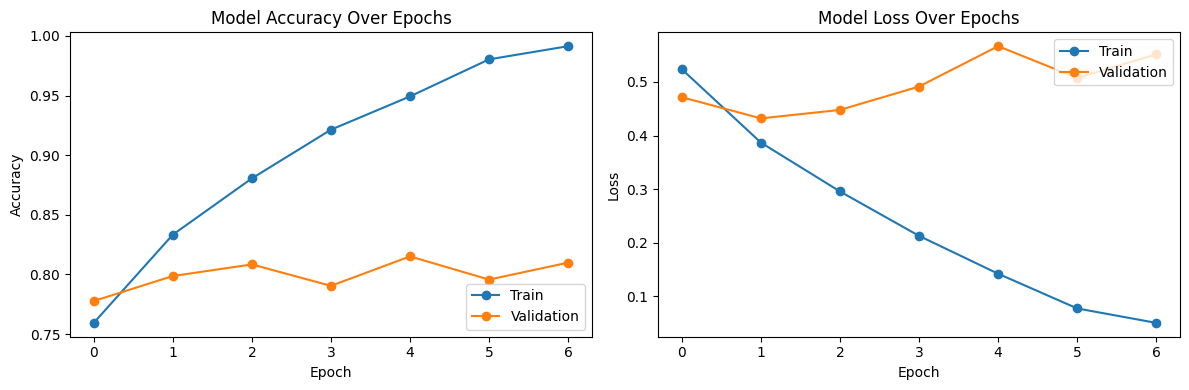

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('mushroom_classification_model_v2.h5')

print("Model loaded successfully.")


Model loaded successfully.


In [7]:
import numpy as np
import pandas as pd

# Load images and metadata
images = np.load('mushroom_images.npy')
df_metadata = pd.read_pickle('mushroom_metadata.pkl')

# Prepare labels
y = df_metadata['edible'].values


In [8]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(images))

# Split the data into train+val and test sets
idx_train_val, idx_test, y_train_val, y_test = train_test_split(
    indices, y, test_size=0.2, stratify=y, random_state=42)

# Split train+val into train and validation sets
idx_train, idx_val, y_train, y_val = train_test_split(
    idx_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

# Get the images
X_train = images[idx_train]
X_val = images[idx_val]
X_test = images[idx_test]


In [9]:
# Get predicted probabilities for the test set
y_pred_probs = model.predict(X_test).flatten()

# Get predicted labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)


53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 473ms/step


In [10]:
# Get the metadata for the test set
df_test = df_metadata.iloc[idx_test].reset_index(drop=True)

# Create a DataFrame with predictions and true labels
df_results = df_test.copy()
df_results['y_true'] = y_test
df_results['y_pred'] = y_pred
df_results['y_pred_prob'] = y_pred_probs


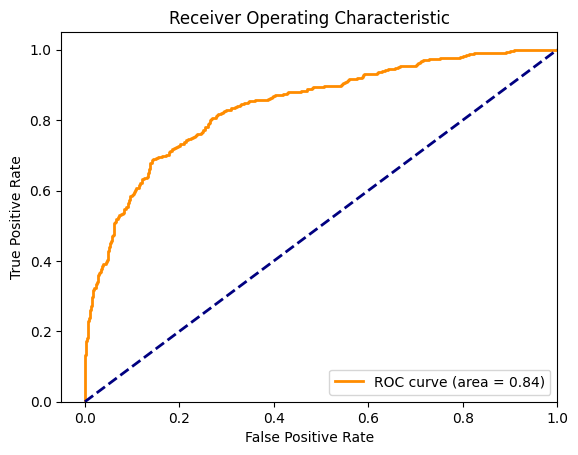

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


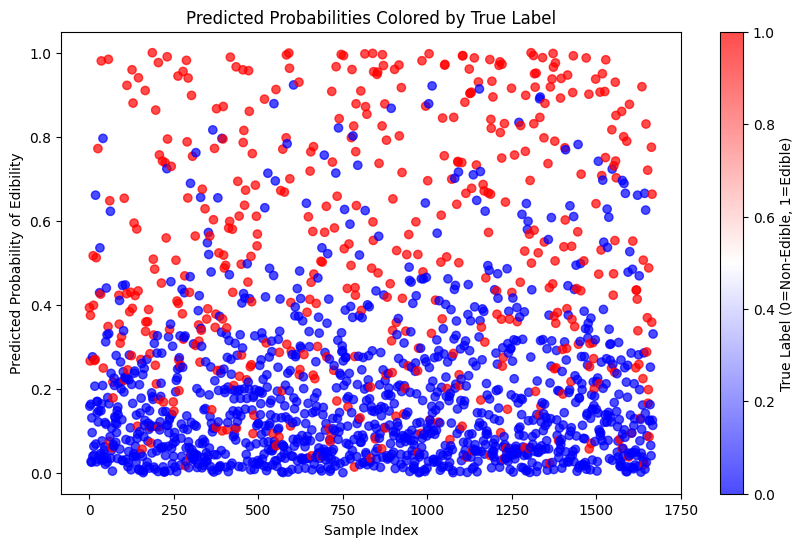

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(y_test)), y_pred_probs, c=y_test, cmap='bwr', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability of Edibility')
plt.title('Predicted Probabilities Colored by True Label')
plt.colorbar(label='True Label (0=Non-Edible, 1=Edible)')
plt.show()


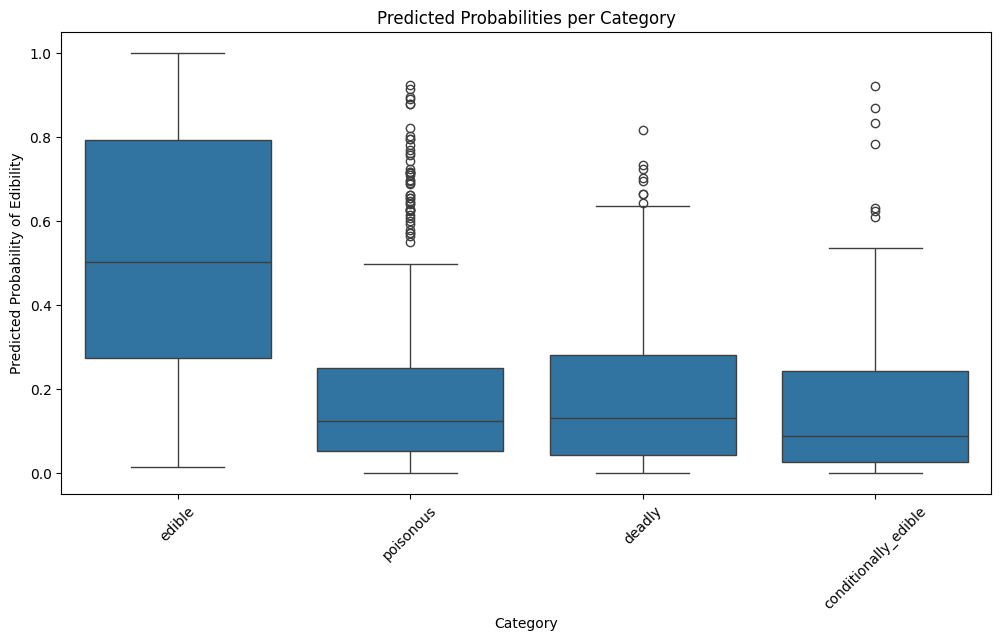

In [14]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='y_pred_prob', data=df_results)
plt.title('Predicted Probabilities per Category')
plt.ylabel('Predicted Probability of Edibility')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.show()


In [21]:
import pandas as pd

categories = ['deadly', 'edible', 'poisonous', 'conditionally_edible']

# Dictionary to hold per-category species performance
category_species_performance = {}

for category in categories:
    # Filter data for the current category
    df_category = df_results[df_results['category'] == category]
    
    # Group by species and calculate performance metrics
    species_performance = df_category.groupby('species').apply(
        lambda x: pd.Series({
            'total_samples': len(x),
            'correct_predictions': (x['y_true'] == x['y_pred']).sum(),
            'incorrect_predictions': (x['y_true'] != x['y_pred']).sum(),
            'accuracy': (x['y_true'] == x['y_pred']).mean()
        })
    ).reset_index()
    
    # Sort species by number of incorrect predictions
    species_performance.sort_values('incorrect_predictions', ascending=False, inplace=True)
    
    # Store in the dictionary
    category_species_performance[category] = species_performance

print("Calculated per-species performance for each category.")



Calculated per-species performance for each category.


/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/43291716.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  species_performance = df_category.groupby('species').apply(
/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/43291716.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  species_performance = df_category.groupby('species').apply(
/var/folders/fq/8_w5ckyn677fszr4vfykf1g8

/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/3065601915.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_with_errors.sort_values('incorrect_predictions', ascending=False, inplace=True)
/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/3065601915.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


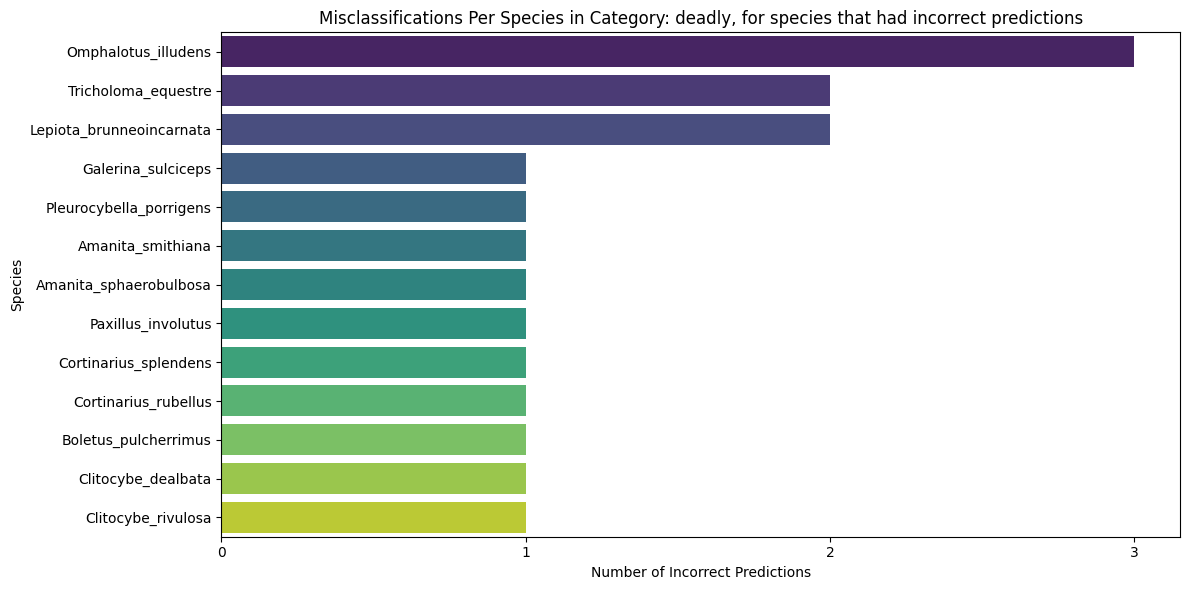

/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/3065601915.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_with_errors.sort_values('incorrect_predictions', ascending=False, inplace=True)
/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/3065601915.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


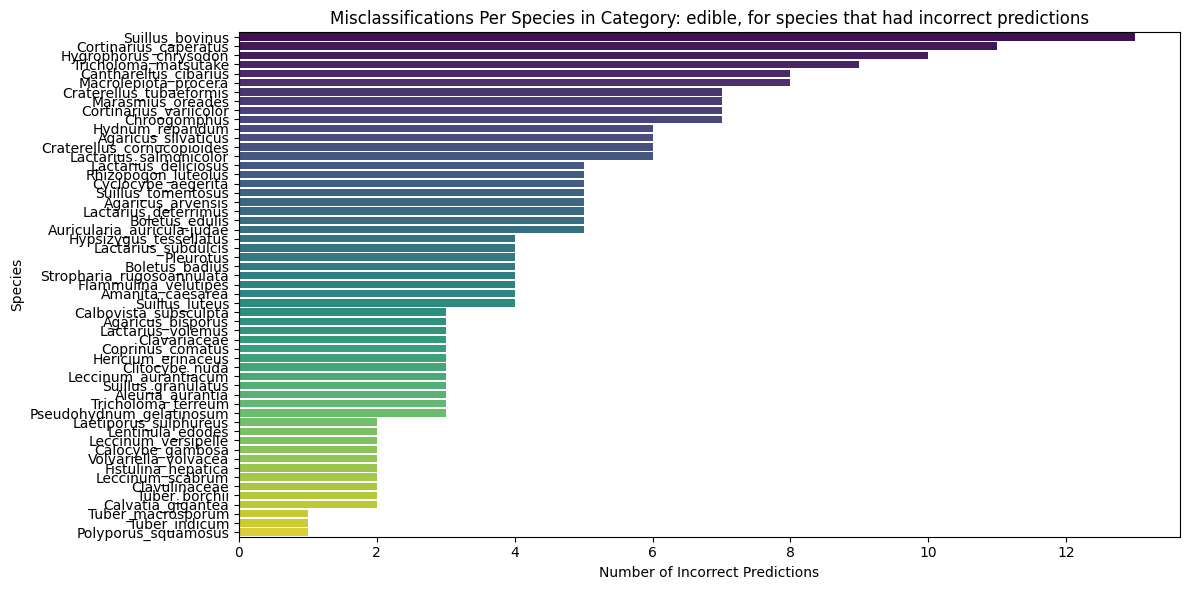

/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/3065601915.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_with_errors.sort_values('incorrect_predictions', ascending=False, inplace=True)
/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/3065601915.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


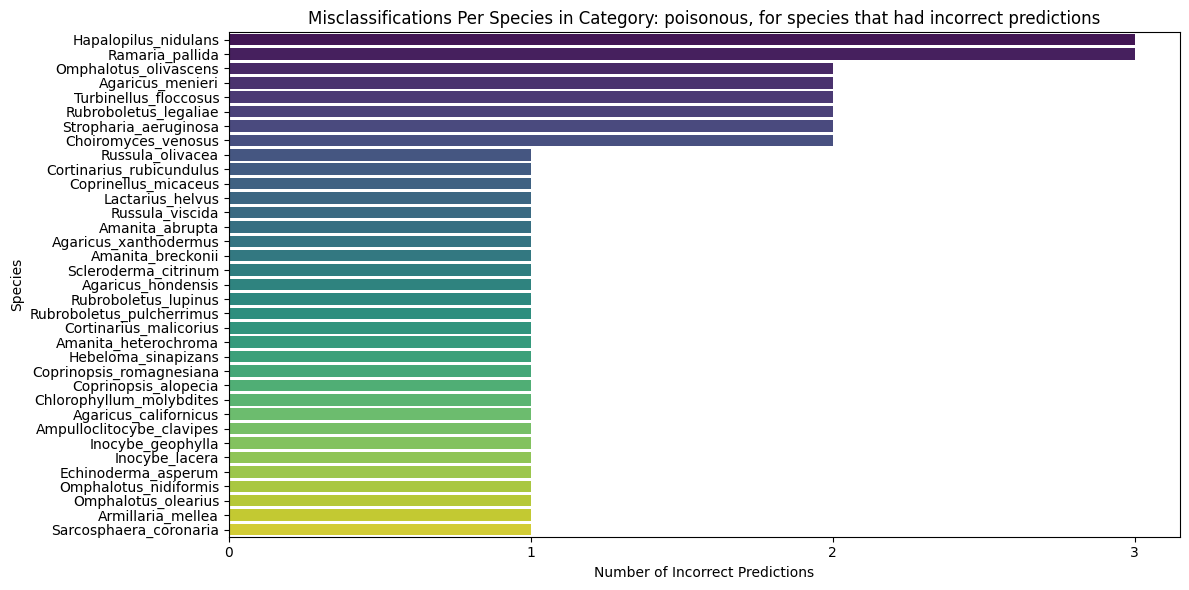

/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/3065601915.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_with_errors.sort_values('incorrect_predictions', ascending=False, inplace=True)
/var/folders/fq/8_w5ckyn677fszr4vfykf1g80000gn/T/ipykernel_899/3065601915.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


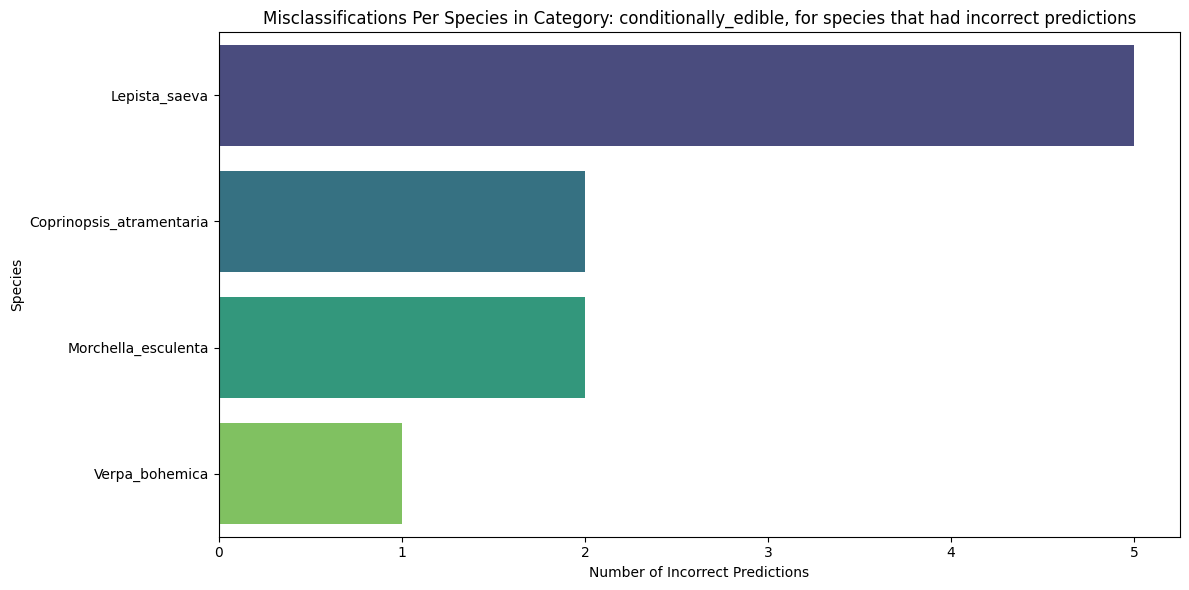

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

for category in categories:
    species_performance = category_species_performance[category]
    
    # Filter out species with zero incorrect predictions
    species_with_errors = species_performance[species_performance['incorrect_predictions'] > 0]
    
    # Check if there are any species with incorrect predictions
    if species_with_errors.empty:
        print(f"No misclassifications in category: {category}")
        continue  # Skip to the next category if none
    
    # Sort species by 'incorrect_predictions' in descending order
    species_with_errors.sort_values('incorrect_predictions', ascending=False, inplace=True)
    
    # Create the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='incorrect_predictions',
        y='species',
        data=species_with_errors,
        palette='viridis',
        order=species_with_errors['species']
    )
    plt.title(f'Misclassifications Per Species in Category: {category}, for species that had incorrect predictions')
    plt.xlabel('Number of Incorrect Predictions')
    plt.ylabel('Species')
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

